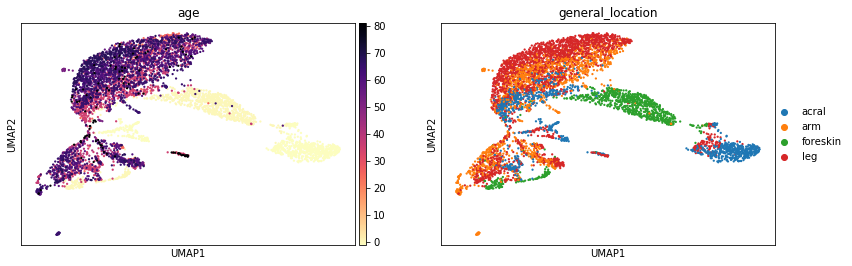

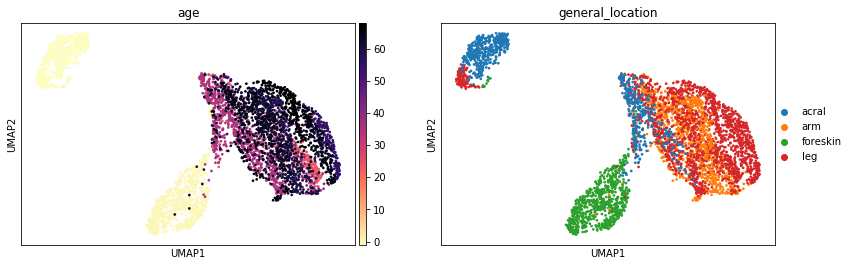

Completed


In [1]:
###############################################
###############################################
# Setup
# This chuck ingests pre-computed variables
###############################################
###############################################

# [Shift + Return] to run chunks 

###############################################

# settings
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

%reload_ext autoreload
%autoreload 2
from scanpy_helpers import *
warnings.filterwarnings('ignore')
%matplotlib inline

# import data from s3
for file in ['adata_subset1', 'adata_subset2', 'full_adata', 'pre_adata','adata_subset1_KRT','raw_adata']:
#     ! aws s3 cp s3://{s3dir}/{file}.p {wkdir}/
    var = pickle.load((open(f'{wkdir}/{file}.p', 'rb')))
    exec(f'{file} = var')
    del var

# drop patients due to low cell count
adata_subset2_filtered = adata_subset2[[x not in ['A1015LM',
                                                'A1017LM',
                                                'A1012M'] for x in adata_subset2.obs.patient.tolist()]] 

# plot full data
sc.pl.umap(full_adata, color=['age','general_location'], cmap = 'magma_r')
sc.pl.umap(adata_subset2_filtered, color=['age','general_location'], cmap = 'magma_r')

print('Completed')


In [ ]:
# Determine correlation between cell-wise txn noise and cell counts
input_adata = adata_subset2
med_list = []
count_list = []
patient_list = []
for x in set(input_adata.obs.patient):
    df_slice = input_adata.obs.filter(regex=x).dropna()
    count_list.append(len(df_slice))
    med_list.append(df_slice.iloc[:,0].median())
    patient_list.append(x)

plot_df = pd.DataFrame({'median':med_list,
                        'counts':count_list,
                        'patient':patient_list})

print(ggplot(plot_df, aes('counts','median',label='patient'))
      +theme_bw()   
      +geom_text())

print(plot_df.sort_values('counts').head())


In [ ]:
# cell-wise transcription noise vs grouping
input_adata = adata_subset2_filtered
groupby = 'age_group'
plot_df = (input_adata
           .obs
           .loc[:, [f'{x}' for x in input_adata.obs.columns if x.startswith('noise')] + [groupby]])
plot_df = pd.melt(plot_df, id_vars=groupby)

# plot
plotnine.options.figure_size=(4,4)
print(ggplot(plot_df)
         +theme_bw()
         +theme(axis_text_x=element_text(angle=90))
         +geom_boxplot(aes(groupby,'value'))
         +labs(y='transcriptional noise',x='')
         +scale_y_log10())

# Compute the Kruskal-Wallis H-test for independent samples
groups_dict = {}
for group in list(set(plot_df[groupby])):
    group_vec = plot_df[plot_df[groupby] == group]['value'].dropna().tolist()
    groups_dict[group] = group_vec

eval_list = [f'groups_dict["{i}"]' for i in groups_dict.keys()]
eval_subcmd = ','.join(eval_list)
eval_cmd = f'stats.kruskal({eval_subcmd})'
hstat, pval = eval(eval_cmd)
print('H-test: ', hstat, 'p-value', pval)


In [ ]:
# plot age vs median txn noise
input_adata = adata_subset2_filtered
med_list = []
age_list = []
patient_list = []
for x in set(input_adata.obs.patient):
    df_slice = input_adata.obs.filter(regex=x).dropna()
    age_list.append(input_adata.obs[input_adata.obs.patient == x].age.values[0])
    med_list.append(df_slice.iloc[:,0].median())
    patient_list.append(x)

plot_df = pd.DataFrame({'median':med_list,
                        'age':age_list,
                        'patient':patient_list})

print(ggplot(plot_df, aes('age','median'))
      +theme_bw()
      +geom_point(alpha = 0.5, color ='red')
      +geom_text(aes(label='patient')))

r,pval = pearsonr(plot_df.age.values.tolist(), 
         plot_df['median'].values.tolist())
print('R2: ', r**2, 'p-value', pval)


In [ ]:
# # calculate transcription noise per gene
groupby='age_group'
input_adata = adata_subset2_filtered

cat, df = prepare_dataframe(input_adata, 
                  var_names=input_adata.var_names,
                  groupby=groupby)

# coefficient of variation vs age bin
gene_std = df.groupby(groupby).std()
gene_mean = df.groupby(groupby).mean()
gene_coef = gene_std/gene_mean
gene_coef = gene_coef.reset_index()
gene_coef = (gene_coef
             .set_index(groupby)
             .sort_index())

# std vs age bin
# gene_std = df.groupby(groupby).std()
# gene_mean = df.groupby(groupby).mean()
# gene_coef = gene_std
# gene_coef = gene_coef.reset_index()
# gene_coef = (gene_coef
#              .set_index(groupby)
#              .sort_index())

# SNR vs age bin
# gene_std = df.groupby(groupby).std()
# gene_mean = df.groupby(groupby).mean()
# gene_coef = gene_mean/gene_std
# gene_coef = gene_coef.reset_index()
# gene_coef = (gene_coef
#              .set_index(groupby)
#              .sort_index())

r_list=[]
p_list=[]
mu_list=[]
for x in gene_coef.columns:
    r,p = pearsonr([x for x in range(gene_coef.shape[0])], 
                   gene_coef.loc[:, x])
    r_list.append(r)
    p_list.append(p)
    mu_list.append(df.loc[:,x].mean())
coef_df = pd.DataFrame({'gene':gene_coef.columns,
                         'R':r_list,
                         'pval':p_list,
                       'mu':mu_list})
coef_df['R2'] = coef_df['R']**2
coef_df['1-R2'] = 1-coef_df['R2']
condition_cmd = '[((R2 > 0.95) and (mu > 1)) for R2,mu in zip(coef_df["R2"], coef_df.mu)]'
condition_vec = eval(condition_cmd)
coef_df['color'] = condition_vec
coef_df = coef_df.sort_values('pval', ascending=True)
coef_df = coef_df.dropna()

# plot and print 
print(ggplot(coef_df)
      +theme_bw()
      +geom_point(aes('mu','R2', color = 'color'), alpha = 0.5)
      +ggtitle(condition_cmd)
      +labs(y = 'R2', x = 'mean log(exp)'))

print(coef_df[coef_df.color == True])

gene = coef_df[coef_df.color == True].gene
out = symbol2field(gene)
full_report = ['{}: {}\n{}'.format(idx,
                            x['query'],
                            x['summary']) if ('summary' in x.keys()) else '{}: {}\n{}'.format(idx,
                            x['query'],
                            'N/A') for idx, x in enumerate(out)]
output = search_term = ''
[print(x) for x in full_report if search_term in x]

In [ ]:
# look at distribution of covar with respect to age bin ==> ridge plot like
plot_df = gene_coef.T.rename(columns=str).reset_index()
plot_df = pd.melt(plot_df, id_vars='index')
plot_df[groupby] = (plot_df[groupby]
                    .astype(str)
                    .astype(CategoricalDtype(gene_coef.reset_index()[groupby].cat.categories.tolist(), ordered=True)))

print(ggplot(plot_df, aes('value', fill=groupby,
                         color=groupby))
     + theme_bw()
     + geom_density()
     + scale_x_log10()
     + facet_grid(f'{groupby}~'))

print(ggplot(plot_df, aes(groupby, 'value'))
     + theme_bw()
     + scale_y_log10()
     + geom_boxplot())

In [ ]:
# plot expression
gene = 'BIRC6'
input_adata = adata_subset2_filtered
groupby='age_bin'

gene2plots(input_adata, gene, groupby)
sc.pl.umap(input_adata, color=[gene, 'age_group'], cmap='magma_r')
out = symbol2field(gene)
[print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]

# Dev

In [ ]:
input_adata = adata_subset2_filtered
groupby = ['age', 'age_bin', 'age_group']

# cell and gene ids from filtered adata obj
cell_names = input_adata.obs_names.tolist()
gene_names = input_adata.var_names.tolist() + [x for x in pre_adata.index.tolist() if x.startswith('ERCC-')]

# filter raw data
pre_adata_processed = pre_adata.reset_index()
pre_adata_processed = pre_adata_processed[[x in gene_names for x in pre_adata_processed.gene_name]]
pre_adata_processed = pre_adata_processed.loc[:,cell_names]

# process table
pre_adata_T = pre_adata_processed.T
pre_adata_T.columns = gene_names
pre_adata_T = (pre_adata_T
               .reset_index()
               .rename(columns = {'index':'cell_name'}))
pre_adata_T = pd.merge((input_adata
                        .obs
                        .loc[:,groupby]
                        .reset_index()
                        .rename(columns = {'index':'cell_name'})),
                       pre_adata_T,
                       'left',
                       'cell_name')



In [ ]:
# get ERCC's only and plot covar vs mean
ercc_stats = pre_adata_T.filter(regex='ERCC-').describe().T
ercc_stats['covar'] = ercc_stats['std']/ercc_stats['mean']
ercc_stats['log_covar'] = np.log(ercc_stats['covar'])
ercc_stats = ercc_stats.reset_index()
ercc_stats['log10_std'] = np.log10(ercc_stats['std'])
ercc_stats['log10_mean'] = np.log10(ercc_stats['mean'])
ercc_stats['log10_covar'] = np.log10(ercc_stats['covar'])
ercc_stats = ercc_stats.sort_values('mean')

# fit exponential decay to covar
import scipy.optimize

def model_func(t, A, K, C):
    return A * np.exp(-K * t) + C
def fit_exp_nonlinear(t, y):
    opt_parms, parm_cov = scipy.optimize.curve_fit(model_func, t, y, maxfev=1000)
    A, K, C = opt_parms
    return A, K, C

A, K, C = fit_exp_nonlinear(ercc_stats['mean'].values, ercc_stats['covar'].values)
fit_y = model_func(ercc_stats['mean'].values, A, K, C)
ercc_stats['nl_fit'] = fit_y

# fit line to std    
def f(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B

A,B = scipy.optimize.curve_fit(f, ercc_stats['mean'].values, ercc_stats['std'].values)[0] # your data x, y to fit
fit_y_line = f(ercc_stats['mean'].values, A, B)
ercc_stats['l_fit'] = fit_y_line

print(ggplot(ercc_stats)
      +theme_bw()
      +geom_point(aes('mean','covar'))
      +geom_line(aes('mean', 'nl_fit'), color = 'red'))

print(ggplot(ercc_stats)
      +theme_bw()
      +geom_point(aes('mean','std'))
      +geom_line(aes('mean', 'l_fit'), color = 'red'))


In [ ]:
# all_genes_table = pre_adata_T.describe().T
all_genes_table['covar'] = all_genes_table['std']/all_genes_table['mean']
all_genes_table['ercc'] = [x.startswith('ERCC-') for x in all_genes_table.index]

In [ ]:
print(ggplot(all_genes_table.iloc[1:,:])
     +theme_bw()
     +geom_point(aes('mean', 'std', color = 'ercc'), alpha=0.1)
     +scale_x_log10()
     +scale_y_log10())

# entropy
entropy calculated from read count distribution

In [288]:
starting_adata = adata_subset2
groupby = 'patient'

# pre-process
pre_adata = pre_adata.astype(int)
input_adata = pre_adata.loc[:,starting_adata.obs_names.values.tolist()]

# calculate entropy
bin_size = 10
return_df = pd.DataFrame()

for feature in list(set(starting_adata.obs[groupby])):
    feature_slice = input_adata.loc[:, starting_adata[starting_adata.obs[groupby] == feature].obs_names.tolist()]
    entropy_list = []
    binned_entropy_list = []
    med_list = []

    for row in tqdm.tqdm(range(feature_slice.shape[0])):
        # non-binned entropy
        bincounts = np.bincount(feature_slice.iloc[row,:].values)
        binprobs = bincounts / np.sum(bincounts)
        slice_entropy = stats.entropy(binprobs)
        entropy_list.append(slice_entropy)
        # binned entropy
        max_value = np.max(feature_slice.iloc[row,:].values)
        if max_value == 0:
            bin_seq = [0,bin_size,int(bin_size*2)]
        else:
            bin_seq = [x for x in range(0,int(max_value),10)]
            if max_value % bin_size != 0:
                bin_seq = bin_seq + [bin_seq[-1] + bin_size]
        binned_counts,edges = np.histogram(feature_slice.iloc[row,:].values, bins = bin_seq)
        binned_probs = binned_counts / np.sum(binned_counts)
        binned_slice_entropy = stats.entropy(binned_probs)
        binned_entropy_list.append(binned_slice_entropy)
        # median
        med = np.median(feature_slice.iloc[row,:].values)
        med_list.append(med)
        
    slice_df = pd.DataFrame({'entropy':entropy_list,
                             'binned_entropy':binned_entropy_list,
                             'median':med_list})
    slice_df[groupby] = feature
    slice_df['gene'] = feature_slice.index.values.tolist()
    return_df = return_df.append(slice_df)
return_df = pd.merge((starting_adata
                         .obs
                         .loc[:, ['patient', 'age']]
                         .reset_index()
                         .drop('index', axis=1)
                         .drop_duplicates()),
                     return_df, 'right', 'patient')
return_df['ercc'] = [x.startswith('ERCC-') for x in return_df.gene]
    


 41%|████      | 10932/26577 [00:10<00:11, 1342.86it/s]


 82%|████████▏ | 21814/26577 [00:16<00:03, 1314.64it/s]


 33%|███▎      | 8787/26577 [00:06<00:12, 1409.79it/s]


 88%|████████▊ | 23368/26577 [00:17<00:02, 1302.29it/s]


 27%|██▋       | 7099/26577 [00:06<00:17, 1119.05it/s]


 62%|██████▏   | 16494/26577 [00:12<00:07, 1364.22it/s]


 12%|█▏        | 3194/26577 [00:02<00:18, 1255.32it/s]


 60%|█████▉    | 15937/26577 [00:12<00:07, 1346.99it/s]


  4%|▍         | 1131/26577 [00:01<00:24, 1042.00it/s]


 44%|████▍     | 11720/26577 [00:08<00:11, 1337.49it/s]


100%|██████████| 26577/26577 [00:18<00:00, 1412.84it/s]

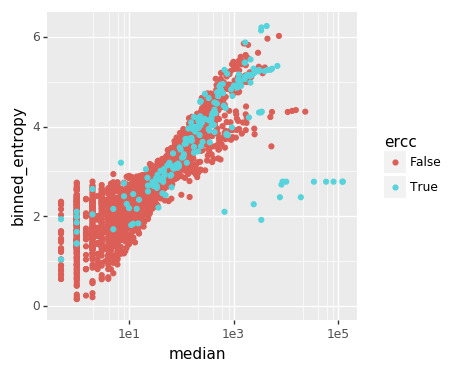

<ggplot: (-9223363275379475733)>


In [365]:
num = 50000
print(ggplot(return_df[return_df.ercc == True].append(return_df[return_df.ercc == False].sample(n=num)))
      +geom_point(aes('median','binned_entropy', color = 'ercc'))
      +scale_x_log10())

In [331]:
# correlations among features
return_df.corr()

,age,entropy,binned_entropy,median,ercc
age,1.000000e+00,-0.143566,-0.096788,-0.004521,-1.256436e-15
entropy,-1.435660e-01,1.000000,0.978523,0.114769,1.552804e-02
binned_entropy,-9.678776e-02,0.978523,1.000000,0.144536,2.174000e-02
median,-4.521326e-03,0.114769,0.144536,1.000000,6.791969e-02
ercc,-1.256436e-15,0.015528,0.021740,0.067920,1.000000e+00


In [370]:
return_df.entropy.values

array([0.        , 0.        , 0.        , ..., 1.62239538, 1.01851942,
       1.00022611])

In [368]:
obs_y = return_df.entropy.values.reshape(-1, 1) # entropy
obs_x = return_df.median.values.reshape(-1, 1) # median
reg = LinearRegression().fit(obs_x, 
                             obs_y)
pred_y = reg.predict(obs_y) # 



,patient,age,entropy,binned_entropy,median,gene,ercc
0,A1015LM,52,0.00000,0.000000,0.0,A1BG,False
1,A1015LM,52,0.00000,0.000000,0.0,A1BG-AS1,False
2,A1015LM,52,0.00000,0.000000,0.0,A1CF,False
3,A1015LM,52,1.24683,0.233792,0.0,A2M,False
4,A1015LM,52,0.00000,0.000000,0.0,A2M-AS1,False


In [290]:
full_corr_df = pd.DataFrame()
adult_only = False
for feature in ['entropy', 'binned_entropy']: 
    corr_df = (pd.merge((starting_adata
             .obs
             .loc[:, ['patient', 'age']]
             .reset_index()
             .drop('index', axis=1)
             .drop_duplicates()),
            (return_df.pivot(index = 'gene',
                            columns = 'patient',
                            values = feature)
             .T
             .reset_index()),
            'right',
            'patient')
            .drop('patient', axis = 1))
    if adult_only == True:
        corr_df = corr_df[corr_df.age > 0]
    corr_df = corr_df[corr_df.columns[1:]].apply(lambda x: x.corr(corr_df['age']))
    corr_df = pd.DataFrame(corr_df).reset_index()
    corr_df.columns = ['gene','R']
    corr_df['R2'] = corr_df['R'] ** 2
    corr_df['feature'] = feature
    full_corr_df = full_corr_df.append(corr_df)


In [366]:
feature = 'binned_entropy'
ascending = False
full_corr_slice = full_corr_df[full_corr_df.feature == feature].sort_values('R', ascending=ascending)

topn = 10
print(full_corr_slice.head(topn))
gene = full_corr_slice.head(topn).gene
out = symbol2field(gene)
out = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]


          gene         R        R2         feature
3766       CLU  0.806126  0.649840  binned_entropy
8342     HLA-C  0.737225  0.543500  binned_entropy
8341     HLA-B  0.728933  0.531344  binned_entropy
18456  PLEKHH2  0.705672  0.497972  binned_entropy
4363      CTSS  0.693396  0.480798  binned_entropy
20755   SCARA3  0.689057  0.474800  binned_entropy
13431    MEIS2  0.675758  0.456649  binned_entropy
24439   TRIM47  0.675379  0.456137  binned_entropy
23151  SYT14P1  0.659896  0.435463  binned_entropy
3232    CDKN1A  0.659457  0.434884  binned_entropy
querying 1-10...done.
Finished.
1 input query terms found dup hits:
	[('SYT14P1', 2)]
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
0:  CLU 
 The protein encoded by this gene is a secreted chaperone that can under some stress conditions also be found in the cell cytosol. It has been suggested to be involved in several basic biological events such as cell death, tumor progression, and neurodegenerat

In [400]:
# implement metric from https://www.biorxiv.org/content/10.1101/526491v1

###############################################
# Correlation between expression and true age
# Returns correlation statistics and gene function annotation
###############################################
###############################################

# Specify number of genes to print from top of list sorted on R2
topn = 20

# Specify whether to use all samples or only adult samples in correlation
adults_only = False

###############################################

from sklearn.linear_model import LinearRegression

ref = 'age'
input_adata = adata_subset2
if adults_only == True:
    input_adata = input_adata[input_adata.obs.age > 0]
corr_age = pd.DataFrame(input_adata.X)
corr_age.columns = input_adata.var_names
corr_age[ref] = input_adata.obs[ref].tolist()

df = corr_age.dropna()._get_numeric_data()
r_list = []
p_list = []
gene_list = []
exp_r2_list = []
for col in [x for x in df.columns.tolist() if x != ref]:
    obs_y = df[col].values.reshape(-1, 1) # expression
    obs_x = df[ref].values.reshape(-1, 1) # age
    reg = LinearRegression().fit(obs_x, 
                                 obs_y)
    pred_y = reg.predict(obs_x)
    r2 = reg.score(obs_x, obs_y, sample_weight=None)

    res_y = np.abs(pred_y - obs_y).flatten()
    rho, pval = stats.pearsonr(obs_x.flatten(), res_y)
    
    r_list.append(rho)
    p_list.append(pval)
    gene_list.append(col)
    exp_r2_list.append(r2)

spear_df = pd.DataFrame({'gene':gene_list,
                        'rho':r_list, 
                        'pval':p_list,
                        'exp_r2':exp_r2_list})
spear_df['pval'] = spear_df['pval'].replace(0, min([x for x in spear_df['pval'] if x>0]))
spear_df['neglog10_pval'] = -np.log10(spear_df['pval'])
spear_df['pass'] = spear_df.neglog10_pval > -np.log10(0.05/len(df))
spear_df['abs_rho'] = np.abs(spear_df['rho'].values)



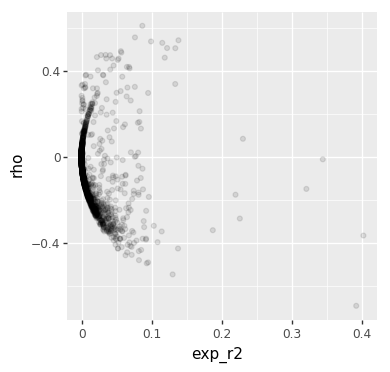

<ggplot: (-9223363275437732131)>


,rho,pval,exp_r2,neglog10_pval,pass,abs_rho
rho,1.000000,0.181378,-0.181993,-0.186222,-0.341869,-0.321617
pval,0.181378,1.000000,-0.165418,-0.244153,-0.475390,-0.423228
exp_r2,-0.181993,-0.165418,1.000000,0.644893,0.343329,0.618427
neglog10_pval,-0.186222,-0.244153,0.644893,1.000000,0.486362,0.927884
pass,-0.341869,-0.475390,0.343329,0.486362,1.000000,0.712490
abs_rho,-0.321617,-0.423228,0.618427,0.927884,0.712490,1.000000


In [406]:
# rho metric has strong correlation to median expression value

num = 2000
print(ggplot(spear_df.sample(n=num))
      +geom_point(aes('exp_r2','rho'), alpha = 0.1))

spear_df.corr()


In [403]:
spear_df.sort_values('rho', ascending=False).head(20)

,gene,rho,pval,exp_r2,neglog10_pval,pass,abs_rho
195,ADIRF,0.664937,2.470328e-322,0.137772,321.607245,True,0.664937
2222,DPP6,0.660121,2.470328e-322,0.206443,321.607245,True,0.660121
249,AHNAK2,0.648953,2.470328e-322,0.136732,321.607245,True,0.648953
9113,TGFBI,0.639855,2.470328e-322,0.117471,321.607245,True,0.639855
3729,IFI27,0.612203,2.470328e-322,0.086633,321.607245,True,0.612203
8326,SLC25A5,0.598145,2.470328e-322,0.210026,321.607245,True,0.598145
7558,RAMP1,0.574535,2.470328e-322,0.138133,321.607245,True,0.574535
7671,RGCC,0.566651,2.470328e-322,0.076080,321.607245,True,0.566651
2860,FKBP5,0.566546,2.470328e-322,0.091855,321.607245,True,0.566546
1792,CRISPLD2,0.558268,2.470328e-322,0.076151,321.607245,True,0.558268


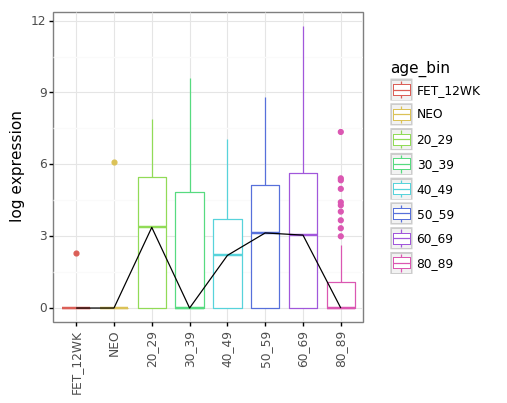

<ggplot: (-9223363275446684626)>


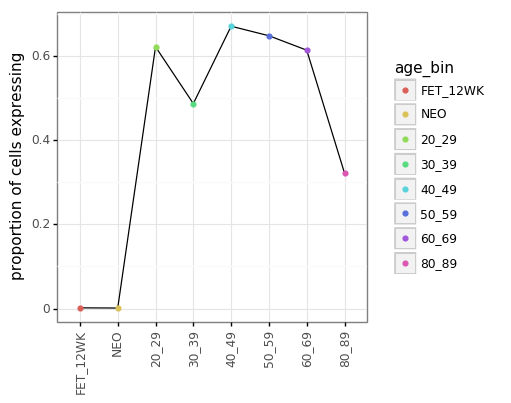

<ggplot: (8761440657493)>


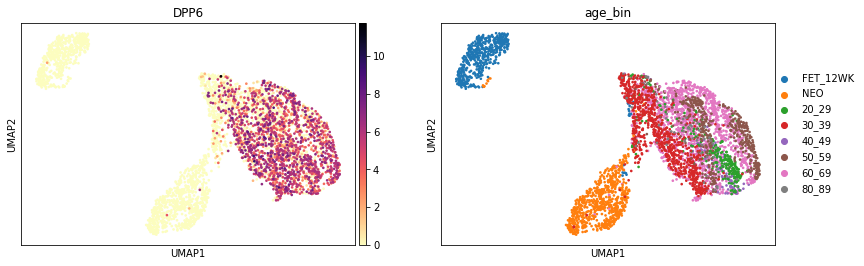

querying 1-1...done.
Finished.
0:  DPP6 
 This gene encodes a single-pass type II membrane protein that is a member of the peptidase S9B family of serine proteases. This protein has no detectable protease activity, most likely due to the absence of the conserved serine residue normally present in the catalytic domain of serine proteases. However, it does bind specific voltage-gated potassium channels and alters their expression and biophysical properties. Variations in this gene may be associated with susceptibility to amyotrophic lateral sclerosis and with idiopathic ventricular fibrillation. Alternative splicing results in multiple transcript variants. [provided by RefSeq, Mar 2014].


[None]

In [405]:
# plot expression
gene = 'DPP6'
input_adata = adata_subset2
groupby='age_bin'

gene2plots(input_adata, gene, groupby)
sc.pl.umap(input_adata, color=[gene, groupby], cmap='magma_r')
out = symbol2field(gene)
[print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]